In [1]:
import pyart
# What can pyart do?
# https://arm-doe.github.io/pyart/API/index.html
# read raw radar observations
# get radar spec
# plot radar data
# etc.


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
# reading a radar file with pyart
file_path = "./data/20210912_0506_RCWF_VOL.647"

radar_data = pyart.io.read_nexrad_archive(file_path)
radar_data

In [4]:
# checking data structure of "pyart.core.radar.Radar" object
radar_data.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (8640,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float32 and shape: (8640,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	differential_reflectivity:
		data: <ndarray of type: float32 and shape: (8640, 1832)>
		units: dB
		standard_name: log_differential_reflectivity_hv
		long_name: log_differential_reflectivity_hv
		valid_max: 7.9375
		valid_min: -7.875
		coordinates: elevation azimuth range
		_FillValue: -9999.0
	clutter_fi

In [5]:
# make sweep angle dictionary
angle_list = list(radar_data.fixed_angle["data"])
sweep_angle_dict = {sweep_number:round(angle, 1) for sweep_number, angle in enumerate(angle_list)}
sweep_angle_dict

{0: 0.5,
 1: 0.5,
 2: 0.9,
 3: 0.9,
 4: 1.3,
 5: 1.3,
 6: 1.8,
 7: 2.4,
 8: 3.1,
 9: 4.0,
 10: 5.1,
 11: 6.4,
 12: 8.0,
 13: 10.0,
 14: 12.0,
 15: 14.0,
 16: 16.7,
 17: 19.5}

In [6]:
# available fields in data
radar_data.fields.keys()

dict_keys(['differential_reflectivity', 'clutter_filter_power_removed', 'cross_correlation_ratio', 'reflectivity', 'differential_phase', 'spectrum_width', 'velocity'])

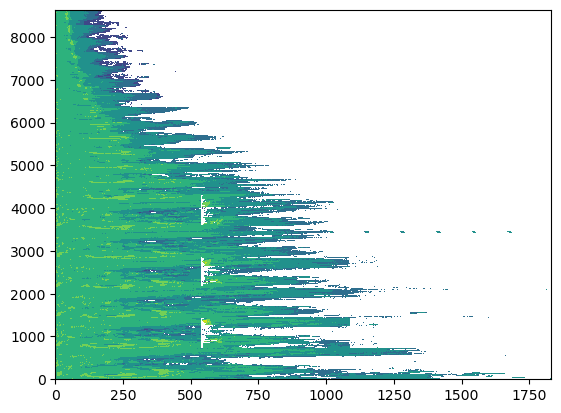

In [7]:
# let's see how the raw data actually look like
import matplotlib.pyplot as plt

# extract radar reflectivity data only but one volume scan without any projection
field = "reflectivity"
data = radar_data.fields[field]['data']

plt.contourf(data)

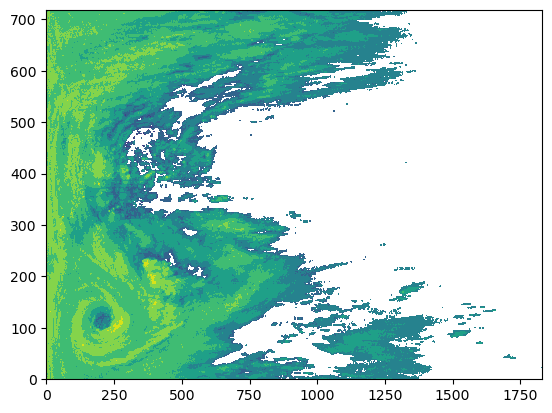

In [ ]:
# how about one sweep data?
swp = radar_data.extract_sweeps([0])
swp_data =swp.fields[field]['data']
plt.contourf(swp_data)

# yes, we need to project on the polar coodinate...

In [8]:
# use azimuthal equidistant projection

import cartopy

# set radar location as the projection origin
lat = radar_data.latitude['data'][0]
lon = radar_data.longitude['data'][0]
proj = cartopy.crs.AzimuthalEquidistant(central_latitude=lat, central_longitude=lon)

# set boundary of the projecting area
max_range = radar_data.instrument_parameters['unambiguous_range']['data'][0]
proj.bounds = (-max_range, max_range, -max_range, max_range) # x_lower, x_upper, y_lower, y_upper

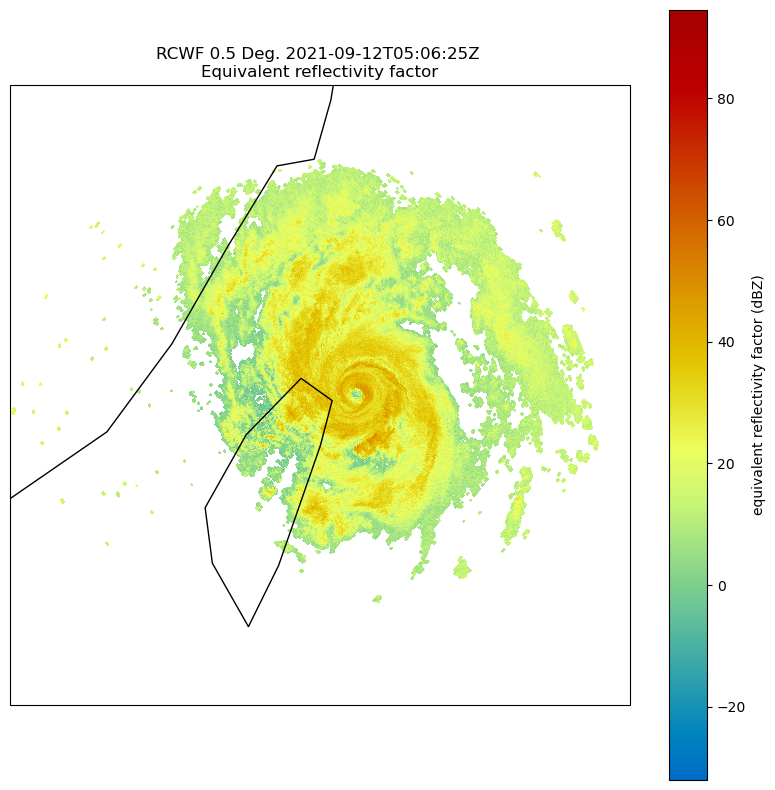

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# plot radar data (the most simple version)

# set parameters
variable = "reflectivity"
sweep_number = 0

# make canvas
display = pyart.graph.RadarMapDisplay(radar_data)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=proj)

# plot ppi
kwargs = {
    "field" : variable, # plot which variable
    "sweep" : sweep_number, # plot which sweep
    "ax" : ax,
    "fig" : fig
}
display.plot_ppi_map(**kwargs)

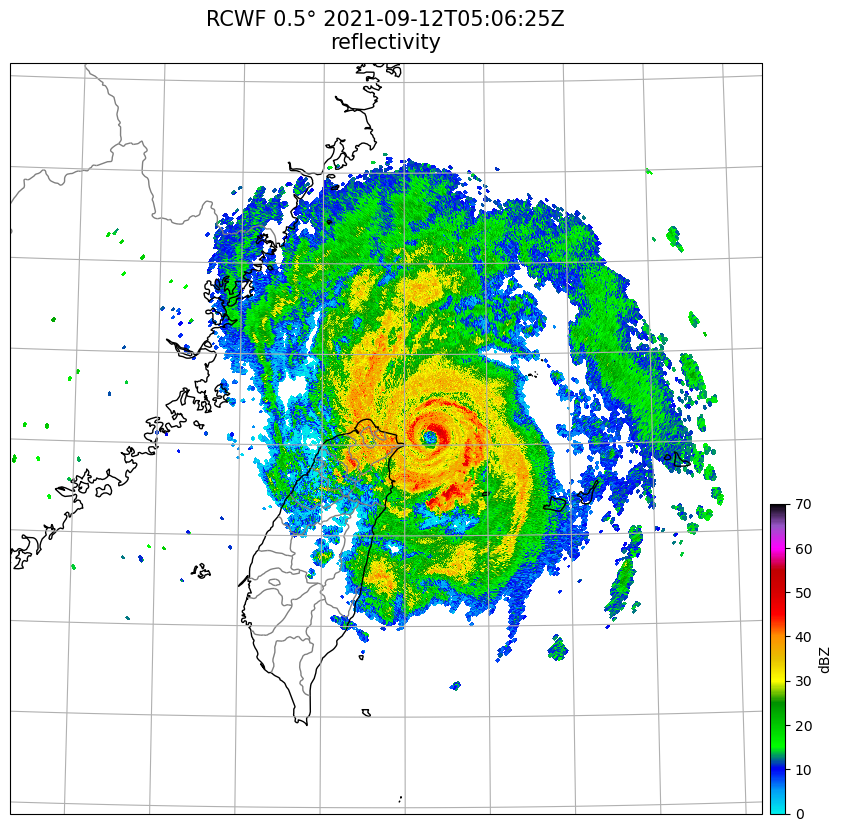

In [10]:
# but if you want to make figure more beautiful

# set parameters
variable = "reflectivity"
sweep_number = 0

# make canvas
display = pyart.graph.RadarMapDisplay(radar_data)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=proj)

# plot ppi
kwargs = {
    "field" : variable,
    "sweep" : sweep_number,
    "vmin" : 0,
    "vmax" : 70,
    "cmap" : "pyart_NWSRef",
    "title_flag" : False,
    "colorbar_flag" : False,
    "ax" : ax,
    "fig" : fig,
    "lat_lines" : np.arange(-90, 90, 1),
    "lon_lines" : np.arange(-180, 180, 1),
    "resolution" : "10m"
    }
display.plot_ppi_map(**kwargs)

# set colorbar
kwargs = {
    "ax" : ax,
    "orientation" : "vertical",
    "pad" : 0.01,
    "fraction" : 0.02,
    "anchor" : (0, 0.022),
    "label" : "dBZ"
    }
plt.colorbar(display.plots[0], **kwargs)

# set title
station_name = radar_data.metadata["instrument_name"]
sweep_angle = sweep_angle_dict.get(sweep_number)
time = radar_data.time["units"].split(" ")[-1]
variable_name = variable.replace("_", "")
title_text = f"{station_name} {sweep_angle}° {time}\n{variable_name}"
plt.title(title_text, fontsize=15, pad=10)

plt.show()

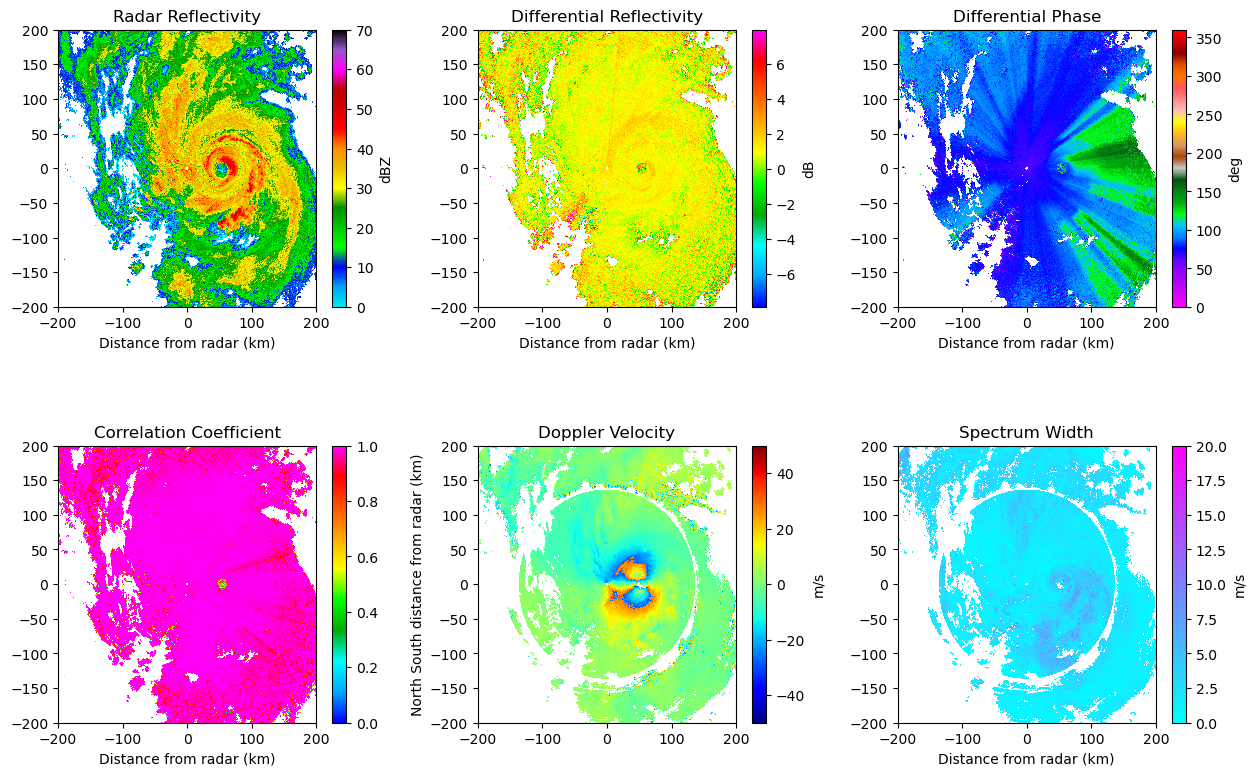

In [42]:
# plot several variable together
sweep_number = 0
# start plotting
fig = plt.figure(figsize=(15, 9))
# set maximum range to plot
rmax = 200

# display without map
display = pyart.graph.RadarDisplay(radar_data)

# plot polarimetric variables together
ax = fig.add_subplot(231)
display.plot('reflectivity',sweep_number, ax=ax,vmin=0., vmax=70.,
             title='Radar Reflectivity', colorbar_label='dBZ', cmap='pyart_NWSRef',
             axislabels=('Distance from radar (km)', ''))
            #  projection=map_proj)
display.set_limits((-rmax, rmax), (-rmax, rmax), ax=ax)

ax = fig.add_subplot(232)
display.plot('differential_reflectivity',sweep_number, ax=ax,
             title='Differential Reflectivity', colorbar_label='dB',
             axislabels=('Distance from radar (km)', ''))
            #  projection=map_proj)
display.set_limits((-rmax, rmax), (-rmax, rmax), ax=ax)

ax = fig.add_subplot(233)
display.plot('differential_phase',sweep_number, ax=ax,
             title='Differential Phase', colorbar_label='deg',
             axislabels=('Distance from radar (km)', ''))
display.set_limits((-rmax, rmax), (-rmax, rmax), ax=ax)

ax = fig.add_subplot(234)
display.plot('cross_correlation_ratio',sweep_number, ax=ax,
             title='Correlation Coefficient', colorbar_label='',
             axislabels=('Distance from radar (km)', ''))
            #  projection=map_proj)
display.set_limits((-rmax, rmax), (-rmax, rmax), ax=ax)


# Doppler mode plot
if sweep_number <5:
    sweep_number=sweep_number+1
    
ax = fig.add_subplot(235)
display.plot('velocity', sweep_number, ax=ax, title='Doppler Velocity',
             colorbar_label='m/s',vmin=-50., vmax=50.,cmap='jet',
             axislabels=('', 'North South distance from radar (km)'))
            #  projection=map_proj)
display.set_limits((-rmax, rmax), (-rmax, rmax), ax=ax)

ax = fig.add_subplot(236)
display.plot('spectrum_width',sweep_number, ax=ax,vmin=0., vmax=20.,
             title='Spectrum Width', colorbar_label='m/s',cmap='cool',
             axislabels=('Distance from radar (km)', ''))
            #  projection=map_proj)
display.set_limits((-rmax, rmax), (-rmax, rmax), ax=ax)

# adjust space between plots
plt.subplots_adjust(wspace=0.3, hspace=0.5)

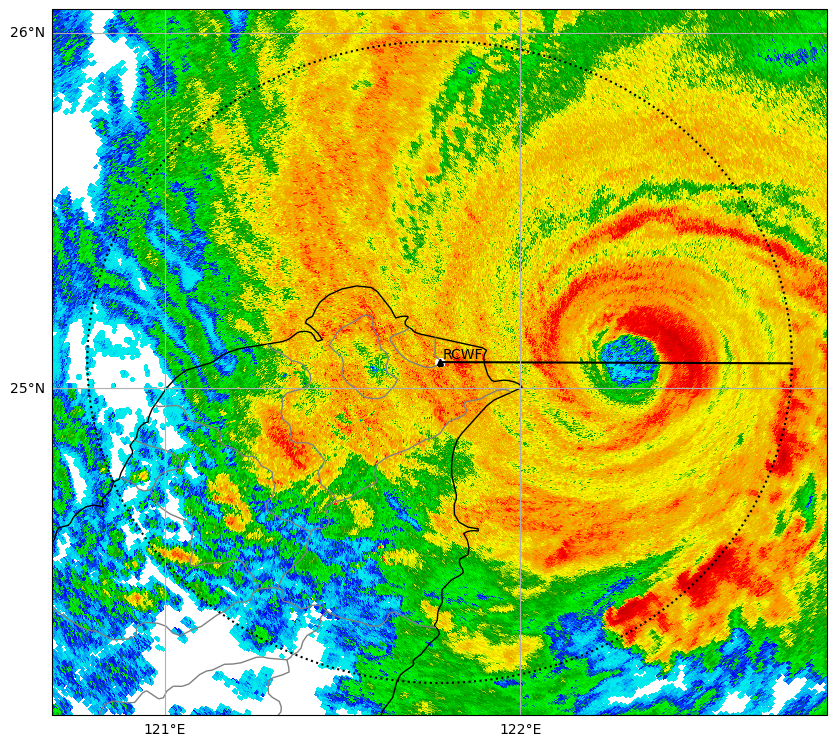

In [46]:
# plot PPI cross-section
# --- set cross-section ---
#   cross-section originate from radar site
#   angle start from north = 0 deg
# --------------------------------------------
angle = [90]  # degree (you can set multiple degrees)
length = 100             # km

# check cross-section position
def get_xx_yy(length,angle):
    import math
    xx = length*1000*math.sin(angle*math.pi/180)
    yy = length*1000*math.cos(angle*math.pi/180)
    return xx,yy


# display without map
display = pyart.graph.RadarMapDisplay(radar_data)

# plot PPI 
fig = plt.figure(figsize=(10, 10))

kwargs = {
    "field" : variable,
    "sweep" : 0,
    "vmin" : 0,
    "vmax" : 70,
    "cmap" : "pyart_NWSRef",
    "title_flag" : False,
    "colorbar_flag" : False,
    "ax" : 111,
    "fig" : fig,
    "projection" : proj,
    "lat_lines" : np.arange(-90, 90, 1),
    "lon_lines" : np.arange(-180, 180, 1),
    "resolution" : "10m"
    }

display.plot_ppi_map(**kwargs)
# plot cross-section line
xx,yy = get_xx_yy(length,angle[0])
display.plot_line_xy(np.array([0,xx]), np.array([0,yy]),color='k',line_style='-')

# add range ring
display.plot_range_ring(length, linestyle=":")

#add radar location and name
display.plot_point(radar_data.longitude['data'][0], radar_data.latitude['data'][0], symbol='k^',label_text=radar_data.metadata['instrument_name'],markersize=5)

In [47]:
# create cross-section data
xsect = pyart.util.cross_section_ppi(radar_data,angle)

xsect.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (18,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float32 and shape: (18,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	differential_reflectivity:
		data: <ndarray of type: float32 and shape: (18, 1832)>
		units: dB
		standard_name: log_differential_reflectivity_hv
		long_name: log_differential_reflectivity_hv
		valid_max: 7.9375
		valid_min: -7.875
		coordinates: elevation azimuth range
		_FillValue: -9999.0
	clutter_filter_p

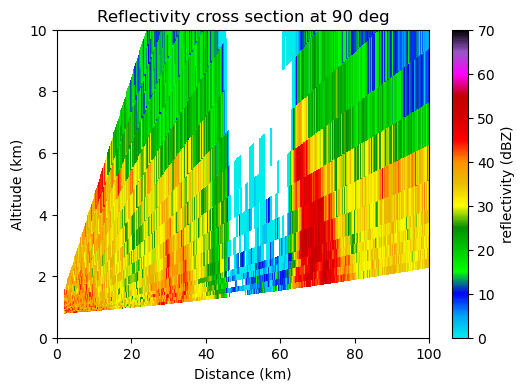

In [48]:
# plot cross-section
display = pyart.graph.RadarDisplay(xsect)

#start plot
fig = plt.figure(figsize=(6,4))

vmin = 0
vmax = 70


#plot cross section
field_name = xsect.fields[variable]['long_name']

kwargs ={
    "field" : variable, 
    "sweep" : 0,
    "fig" : fig,
    "cmap" : "pyart_NWSRef",
    "vmin" : vmin, 
    "vmax": vmax, 
    "colorbar_label" : 'reflectivity (dBZ)', 
    "axislabels" : ('Distance (km)','Altitude (km)'), 
    "title" : field_name+' cross section at '+str(angle[0])+' deg'
}

display.plot(**kwargs)
display.set_limits(xlim=(0,length),ylim=(0,10))